# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

### 1. Imports

Implementations of LSTM and GRU classifiers, the main extraction method, and our own implenetations of DFACrawler, swapTracker, swapSuggester, FreqAnalysis, and rotationChecker

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract
import time
from memory_profiler import profile
import FalseWordGenerator as FWG

import ALPHABET_7
ALPHABET = ['e','t','a','o','s','i','n']

#from ALGO_CODE.swapController import swapTracker, swapSuggester
#from ALGO_CODE.decypherTools import DFACrawler, FreqAnalysis, rotationChecker

### 2. Training

#### 2.1. Define a Language
Here we provide examples of meaningful english words, and meaningless english words

In [2]:
MEANINGFUL_WORDS = ALPHABET_7.WORDS

MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)

def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
#alphabet = "etaoins" ##The RNN and DFA use this

In [3]:
print(target("IS"))
print(target("EAT"))
print(target("TINS"))
print(target('NOT'))

False
True
False
True


#### 2.2. Create a Train Set

train_set is automatically filled out with meaningfully words, meaningless words, and their classificatation values

In [4]:
#meaningfullClass = [word for word in MEANINGFUL_WORDS]
#meaninglessClass = [word for word in MEANINGLESS_WORDS]
startingExamples = MEANINGFUL_WORDS + MEANINGLESS_WORDS
train_set = make_train_set_for_target(target,ALPHABET, provided_examples = startingExamples)
#train_set = meaningfullClass + meaninglessClass

made train set of size: 679 , of which positive examples: 203
made train set of size: 679 , of which false examples: 476


In [5]:
print(len(train_set))
#print (train_set)
print (type(train_set))
print(list(train_set.items())[:10])

679
<class 'dict'>
[('i', True), ('e', True), ('n', True), ('o', True), ('s', True), ('t', True), ('a', False), ('ii', True), ('in', True), ('no', True)]


#### 2.3. Create and Train a Network


`RNNClassifier` generates an RNN-Classifier for a given alphabet.
Its optional parameters are:
>1. `num_layers` (default value 2): the number of hidden layers
>2. `hidden_dim` (default value 5): the size of the hidden layers
>3. `input_dim` (default value 3): the size of the input vectors (these networks use embedding, not one-hot encoding)
>4. `RNNClass` (default value `LSTMNetwork`): the RNN architecture (possible values `LSTMNetwork`, `GRUNetwork`)

In [6]:
rnn = RNNClassifier(ALPHABET,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


The function `mixed_curriculum_train(rnn,train_set)` trains the network `rnn` with the given dictionary of labeled examples, `train_set`. Its optional parameters are: 
>1. `stop_threshold` (default $0.001$): the threshold for the average loss of the network on the train set under which training is cut short
>2. `learning_rate` (defualt 0.001): learning rate for optimiser
>2. `length_epochs` (default $5$): explained below
>3. `random_batch_epochs` (default $100$): below
>4. `random_batch_size` (default $20$): below
>5. `single_batch_epochs` (default $100$): below
>6. `outer_loops` (default $3$): below

`mixed_curriculum_train` splits the input dictionary first into batches by length, training for `length_epochs` iterations each of these batches, by order of increasing length. Then for `random_batch_epochs` iterations it will, at each iteration, split the dictionary into random batches of size `random_batch_size` and train each batch for one iteration. After that it will train the dictionary as one big batch for `single_batch_epochs` iterations. It does all of this `outer_loops` times.

This will print some scatter plots of the average loss on the train set. The plots will come in pairs: each time one for the most recent iterations of training where the whole dictionary was trained as one batch, and another for all the iterations the rnn has been trained since its initialisation.

`mixed_curriculum_train` should work for most simple targets without any tinkering. If the network doesn't drop under the stop threshold, you may want to call it again.

current average loss is:  0.5599039717724449
current average loss is:  0.4989838408242807
current average loss is:  0.45280300821682257
current average loss is:  0.425290045132947
current average loss is:  0.4036566074234044


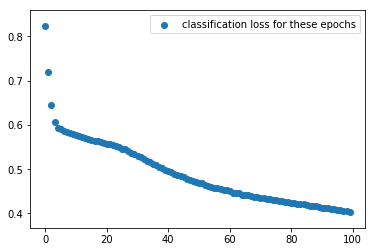

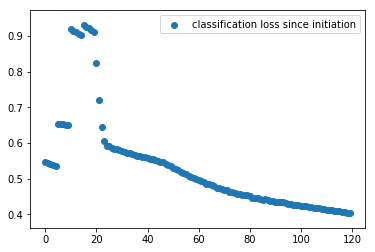

current average loss is:  0.39465794963583856
current average loss is:  0.38779778684186306
current average loss is:  0.38076912566734167
current average loss is:  0.3735566848507686
current average loss is:  0.3661084182132502


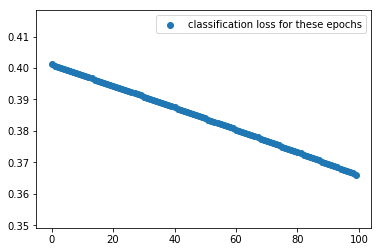

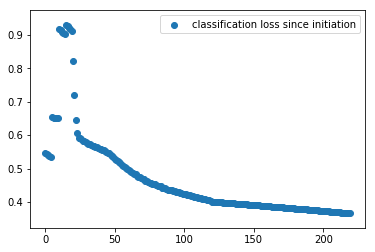

current average loss is:  0.3488898676615381
current average loss is:  0.334486996555476
current average loss is:  0.31533094840153075
current average loss is:  0.2999075244639312
current average loss is:  0.2863778448049498


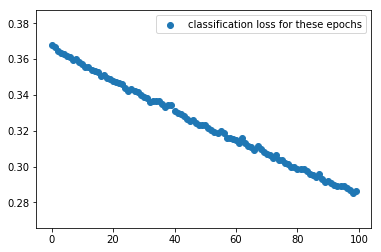

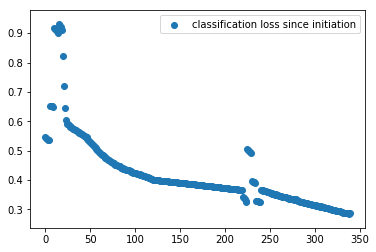

current average loss is:  0.27405922261885585
current average loss is:  0.2669434133088641
current average loss is:  0.2598719196572395
current average loss is:  0.25278687512225007


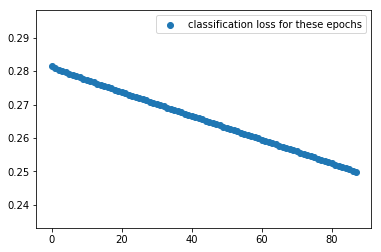

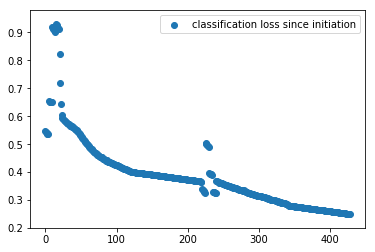

classification loss on last batch was: 0.24993474002439248


In [7]:
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.25)

### 3. Extraction

#### 3.1. Initial Examples

In Section 7.3 of the paper we note that the process sometimes needs one positive and one negative initial sample to get started. We take these from the training set, using the shortest sample from each class.

If extracting from a network you no longer have the train set for, you can also make such a list manually. 
Of course, there is nothing to stop you from having more than one initial sample from each class, or not using any, and so on.

In [8]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)

['i', 'ea']


#### 3.2. Clear the Computation Graph
If you're using our network classes, and just running one network at a time, you don't need this. Still, it's good practice. `renew` function resets the DyNet computation graph and refreshes the calling network's initial vectors.

In [9]:
rnn.renew()

#### 3.3. Extract
It is generally necessary to give the extraction some `starting_examples` to work with, so it doesn't get stuck on a single state automaton (Section 7.3. in the paper). We made those in Section 3.1. of this notebook.

You can set a `time_limit` on the extraction (default $50$ seconds) and the `initial_split_depth` (default $10$) for the initial aggressive refinement (which is described in Section 7.3.1. of our extraction paper).


During extraction, the method will report the counterexamples it finds, how long it took to find each one, and how long it took to refine the observation table (i.e. how long it took to update the $L^*$ automaton) between each two equivalence queries. Every time it starts a new equivalence query, if the proposed DFA has less than $30$ states, it will also display it.

provided counterexamples are: ['i', 'ea']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 1


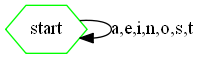

storing provided counterexample of length 2
returning counterexample of length 2:		ea, this counterexample is rejected by the given RNN.
equivalence checking took: 0.038669565999995825
obs table refinement took 0.022
guided starting equivalence query for DFA of size 4


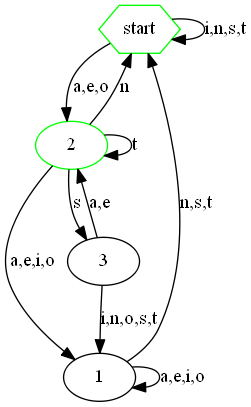

['', 'e']
refining, H size is 1
split wasn't perfect: gotta start over
['ts', 'tn']
returning counterexample of length 2:		aa, this counterexample is accepted by the given RNN.
equivalence checking took: 0.07769656099999622
obs table refinement took 0.035
guided starting equivalence query for DFA of size 14


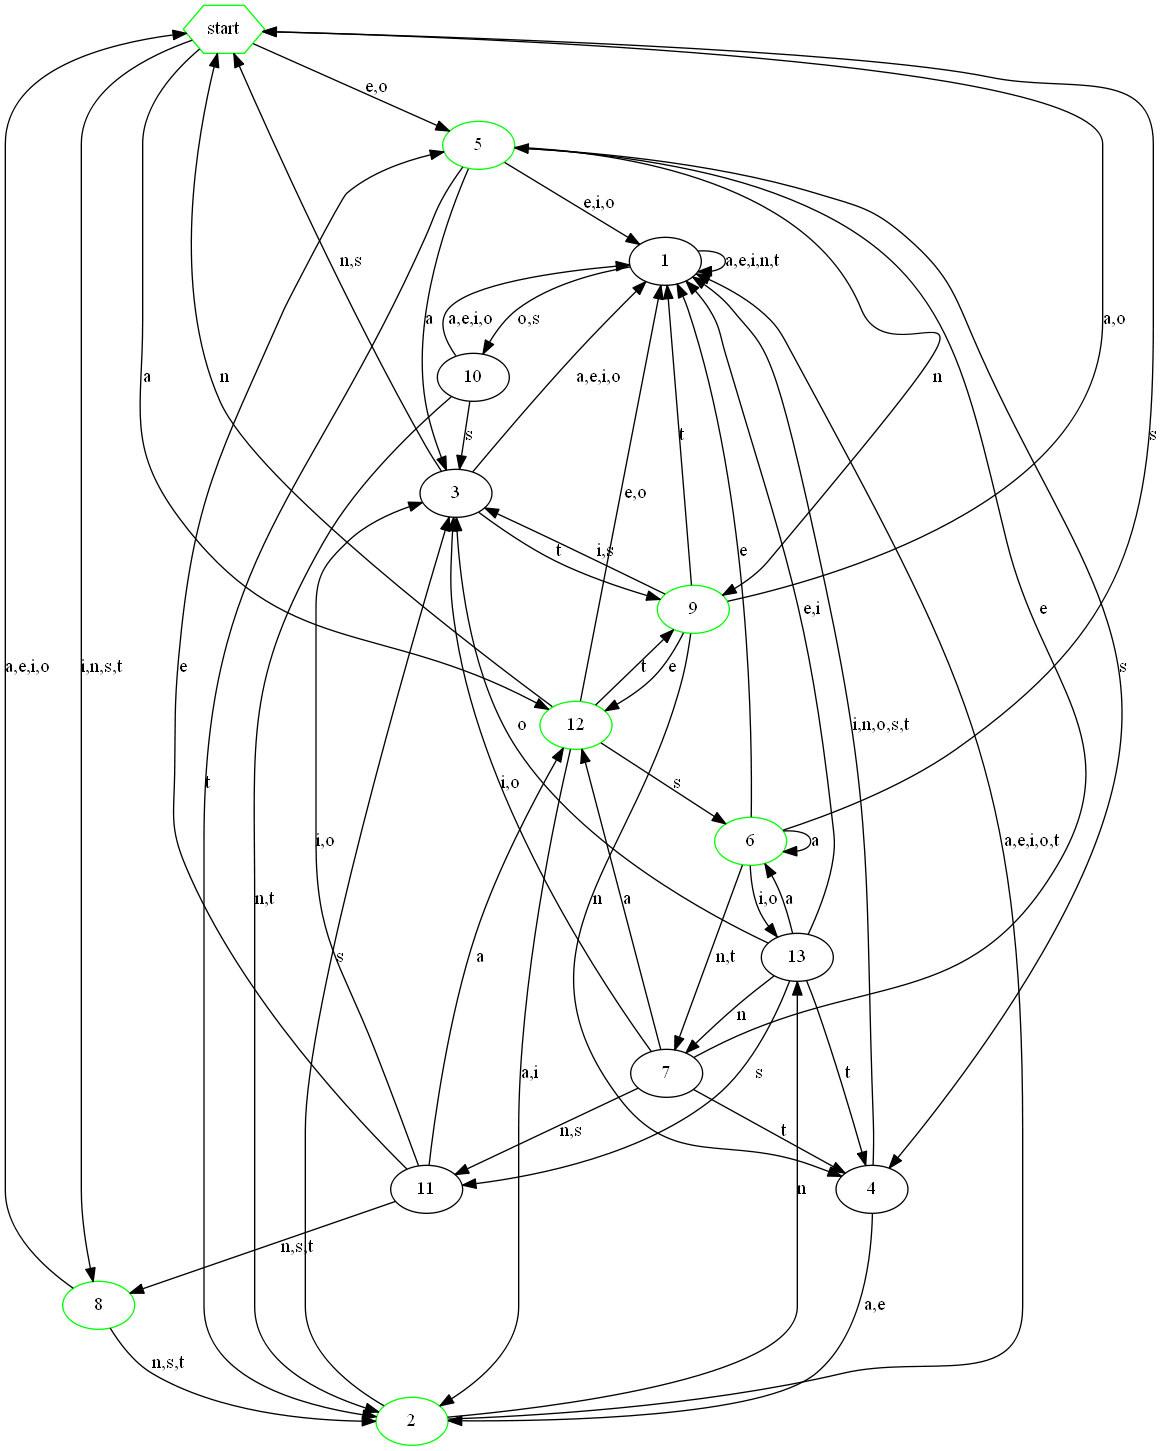

['ts', 'tn']
['et', 'ot']
returning counterexample of length 2:		os, this counterexample is accepted by the given RNN.
equivalence checking took: 0.21122312900000395
obs table refinement took 0.08
guided starting equivalence query for DFA of size 28


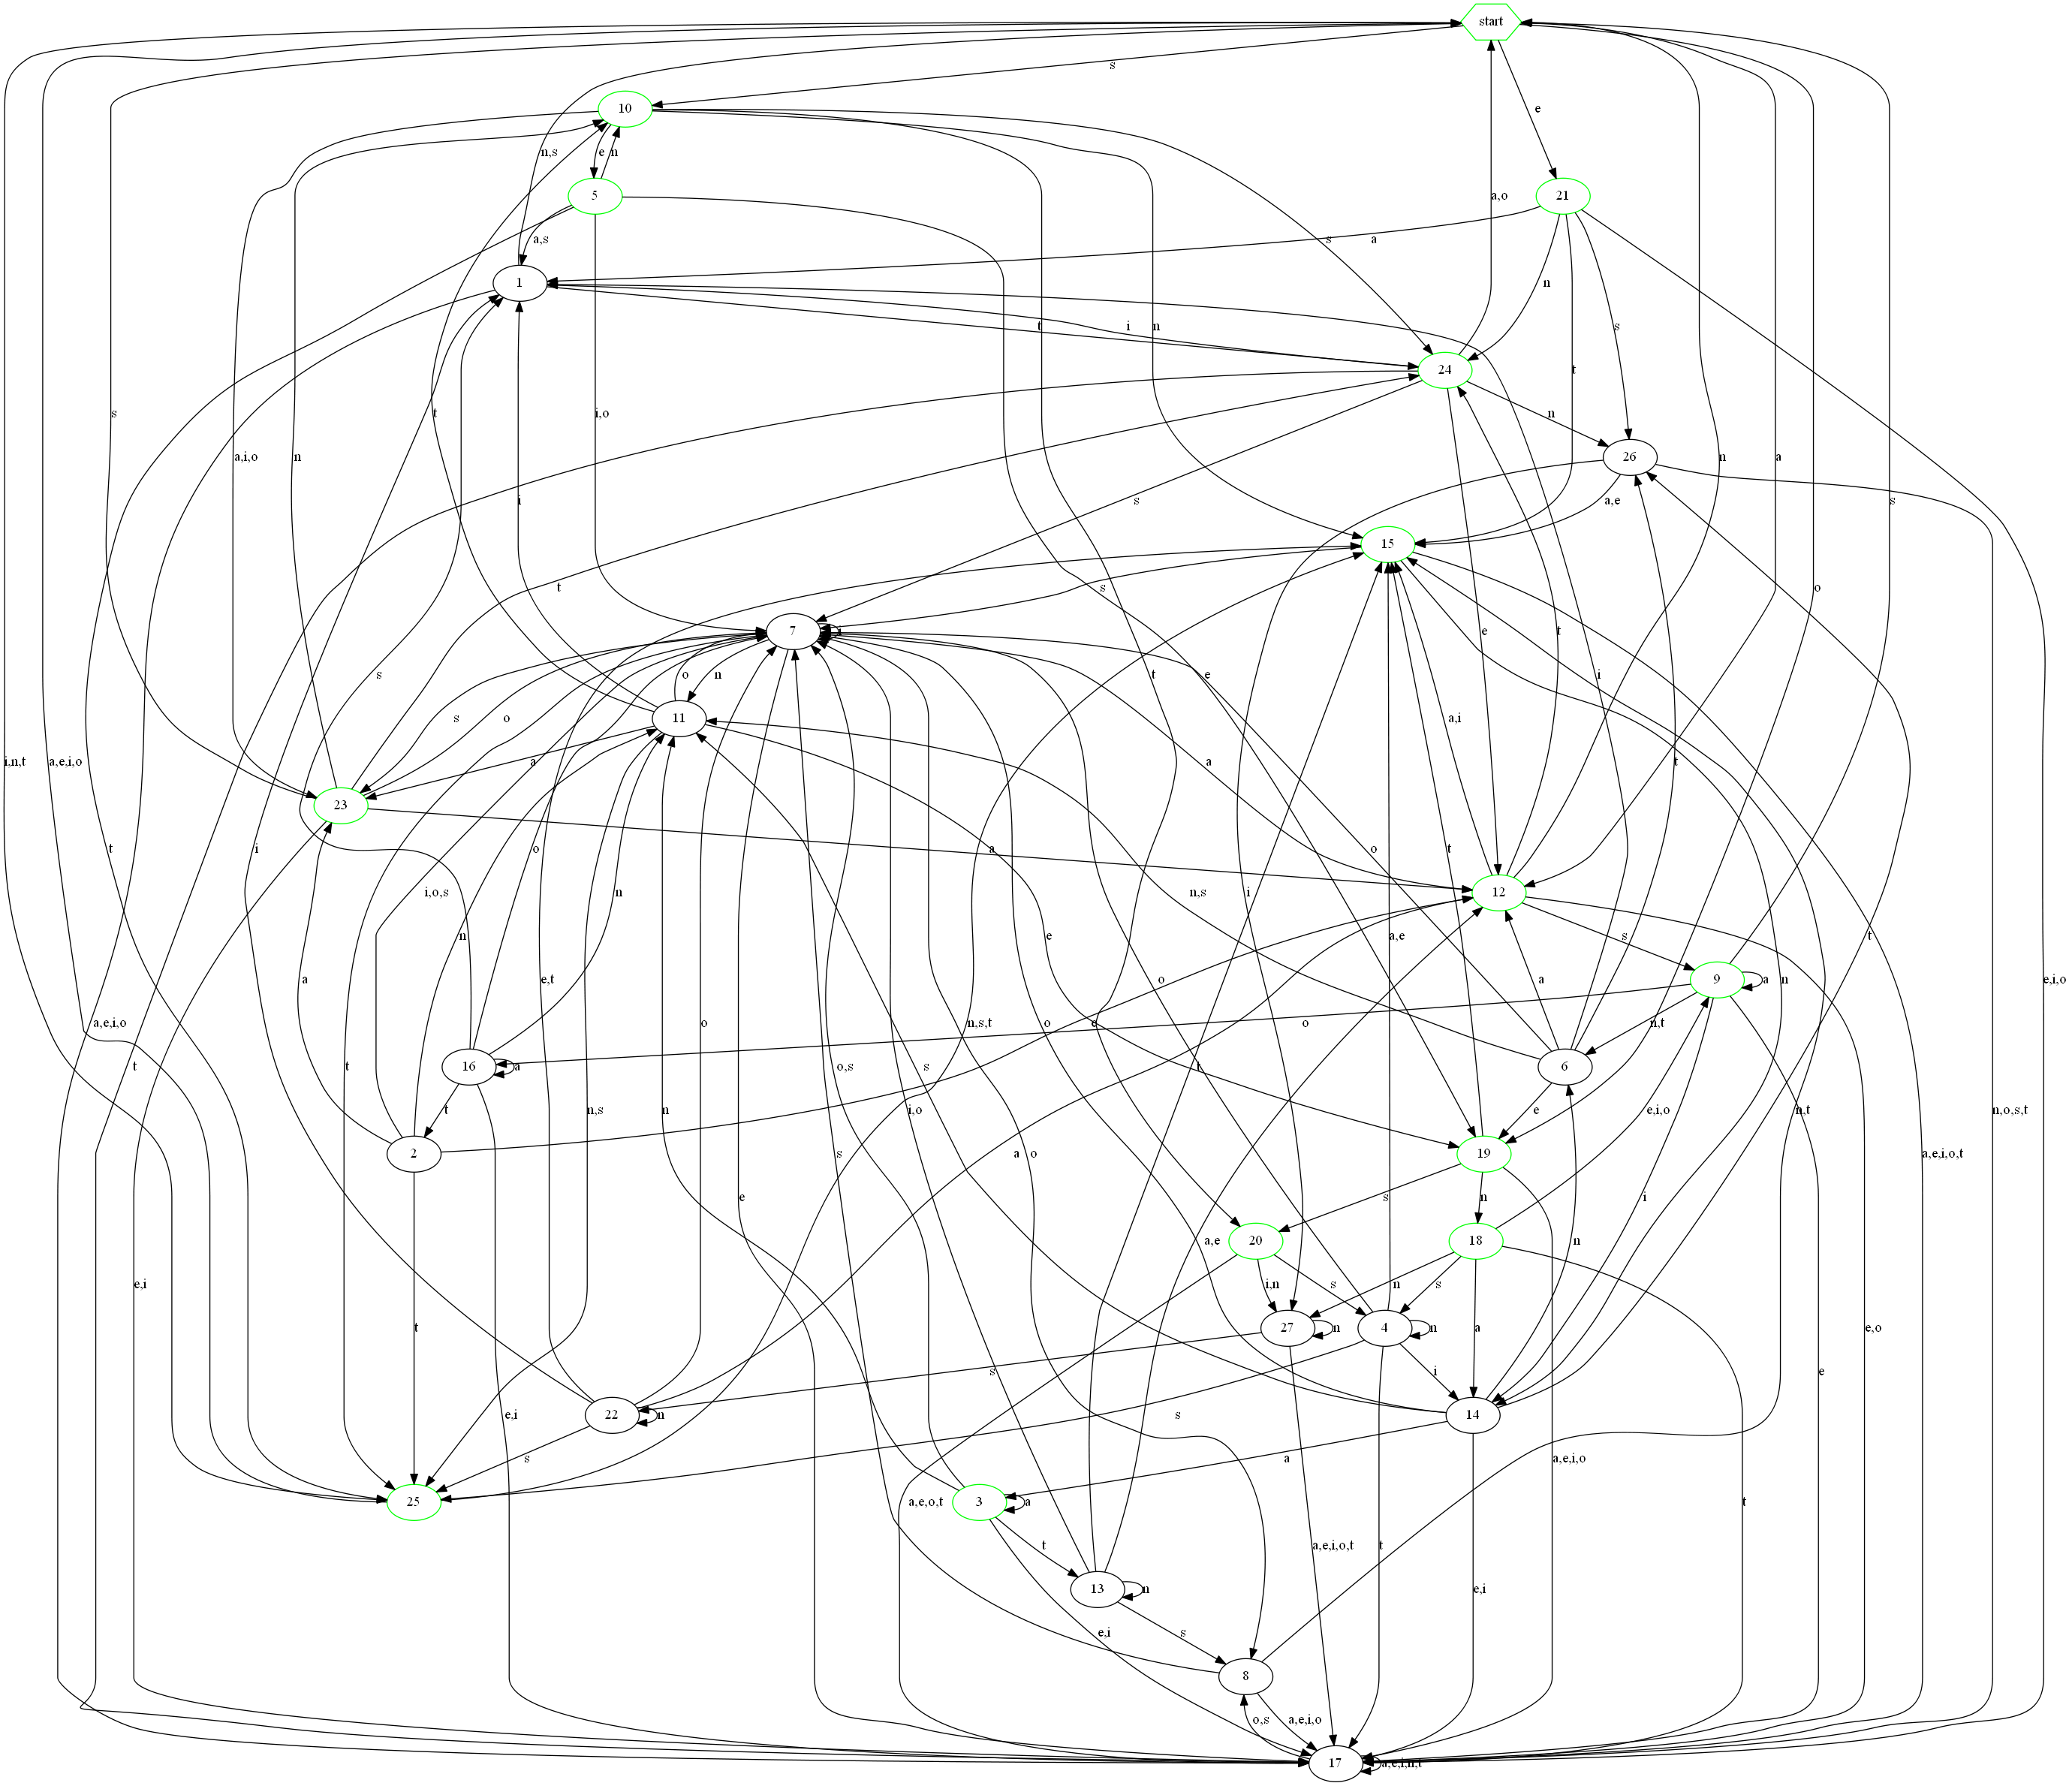

['ts', 'tn']
['et', 'ot']
['oe', 'oi']
['te', 'se']
returning counterexample of length 3:		tes, this counterexample is rejected by the given RNN.
equivalence checking took: 0.8328160530000019
obs table refinement took 0.292
guided starting equivalence query for DFA of size 47
['ts', 'tn']
['et', 'ot']
['oe', 'oi']
['te', 'se']
refining, H size is 1
['ts', 'tn', 'ss']
refining, H size is 2
['tt', 'sn']
['an', 'ii']
returning counterexample of length 3:		ann, this counterexample is rejected by the given RNN.
equivalence checking took: 0.014015115000006517
obs table refinement took 0.521
guided starting equivalence query for DFA of size 82
['ts', 'tn']
['et', 'ot']
['oe', 'oi']
['tt', 'sn']
['an', 'ii']
refining, H size is 1
['is', 'in']
returning counterexample of length 6:		isisin, this counterexample is accepted by the given RNN.
equivalence checking took: 0.014191657000012015
obs table refinement took 3.139
guided starting equivalence query for DFA of size 174
['ts', 'tn']
['et', 'ot'

In [10]:
dfa = extract(rnn,time_limit = 50,initial_split_depth = 10,starting_examples=starting_examples)

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [11]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

testing on train set, i.e. test set is train set
test set size: 679
of which positive: 203 (29.89%)
rnn score against target on test set: 608 (89.54%)
extracted dfa score against rnn on test set: 633 (93.22%)
extracted dfa score against target on rnn's test set: 578 (85.12%)


Rotation Cypher Checker

In [12]:
def rtCyCdecode(message):  # Rotation cypher decode
    msgList = list(message.lower())
    letterList = ['a', 'e', 'i', 'n', 'o', 's', 't']
    convertedMsgList = []

    for i in range(1, len(letterList)):
        convertedMsg = ""
        for letter in msgList:
            lIndex = letterList.index(letter)
            newLIndex = (lIndex + i) % len(letterList)
            convertedMsg += letterList[newLIndex]
        convertedMsgList.append(convertedMsg)

    return convertedMsgList

In [13]:
@profile(precision=8)
def checkRNN(convertedMsgList):
    for convertedMsg in convertedMsgList:
        if rnn.classify_word(convertedMsg):
            print("Cyphered Message is English", convertedMsg, "in RNN")
            return True

In [14]:
@profile(precision=8)
def checkDFA(convertedMsgList):
    for convertedMsg in convertedMsgList:
        if dfa.classify_word(convertedMsg):
            print("Cyphered Message is English", convertedMsg, "in DFA")
            return True

In [15]:
def rtCyChecker(message):  # Rotation cypher checker
    convertedMsgList = rtCyCdecode(message)
    foundKeyRNN = False
    foundKeyDFA = False
    print("Try message in following list", '\n', convertedMsgList)

    startRNN = time.time()
    if checkRNN(convertedMsgList):
        foundKeyRNN = True
    executeTimeRNN = time.time() - startRNN
    print("RNN execution time", executeTimeRNN)

    startDFA = time.time()
    if checkDFA(convertedMsgList):
        foundKeyDFA = True
    executeTimeDFA = time.time() - startDFA
    print("DFA execution time", executeTimeDFA)

    if foundKeyRNN != foundKeyDFA:
        print("RNN and DFA returned different result")

    if not foundKeyRNN and not foundKeyDFA:
        print("No rotation cyphered message founded")

In [16]:
rtCyChecker(message)        # Call above functions

NameError: name 'message' is not defined